In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.special
from scipy.interpolate import interp1d
from functools import cache
from IPython import display
import pandas as pd

import matplotlib

%matplotlib inline

matplotlib.rcParams['font.size'] = 20
matplotlib.rcParams['figure.figsize'] = (14,9)
matplotlib.rcParams['savefig.bbox'] = 'tight'

import multi_distr
from wish_distr import e5s_pdf, e4s_pdf, w5s_pdf, w4s_pdf
import markov

In [2]:
import scipy.stats

In [3]:
@np.vectorize
def w5_phw(w):
    if 1 <= w <= 62:
        return .007
    elif 62 <= w <= 75:
        return .007 + (1 - .007) / (75 - 62) * (w - 62)
    elif 75 < w:
        return 1
    return 0.0

@np.vectorize
def e5_phw(w):
    if 1 <= w <= 73:
        return .006
    elif 73 <= w <= 89:
        return .006 + (1-.006)/(89 - 73) * (w-73)
    else:
        return 0.0

In [4]:
@np.vectorize
def e4_phw(w):
    if 1 <= w <= 8:
        return .051
    elif w == 9:
        return 13/23
    elif w == 10:
        return 1
    return 0.0

@np.vectorize
def w4_phw(w):
    if 1 <= w <= 7:
        return .06
    elif 8 <= w <= 10:
        return [2/3, 1, 1][w-8]
    return 0.0

In [5]:
def uc2phw(u, c):
    hits = np.zeros(np.amax(u) + 1)
    hits[u] = c / sum(c)
    
    phw = hits / np.cumsum(hits[::-1])[::-1]
    return phw

In [10]:
e5s_mult = multi_distr.MultiDistr(e5s_pdf, n_max=90)
w5s_mult = multi_distr.MultiDistr(w5s_pdf, n_max=75)
e4s_mult = multi_distr.MultiDistr(e4s_pdf, n_max=10)
w4s_mult = multi_distr.MultiDistr(w4s_pdf, n_max=10)

In [6]:
edf1 = pd.read_csv('chinese_data/Char_pulls_chinese.csv')
edf2 = pd.read_csv('whale_pulls_kqm_data/whale_pulls_chars.csv')

In [7]:
wdf1 = pd.read_csv('chinese_data/Weapons_pulls_chinese.csv')
wdf2 = pd.read_csv('whale_pulls_kqm_data/whale_pulls_weapons.csv')

In [32]:
def hits_4s(df, hard=10):
    wpity = {}
    hits = []
    pr = None
    
    for i, (wid, rr) in df.iterrows():
        if wid not in wpity:
            wpity[wid] = 0
        
        wpity[wid] += 1
        if rr == 4:
            if  wpity[wid] > hard and pr == 5:
                hits.append(hard)
            else:
                hits.append(wpity[wid])
            wpity[wid] = 0
#             wpity[wid] = max(wpity[wid]-10, 0)
        pr = rr
    
    return hits

In [45]:
def plet(xx,dist, u1,c1, u2,c2):
    plt.subplot(311)
    plt.plot(uc2phw(u1, c1))
    plt.plot(uc2phw(u2, c2))
    b = dist(xx)
    plt.plot(xx, b / np.cumsum(b[::-1])[::-1])
    plt.legend(['chinese_data', 'kqm_data', 'theory'])
    plt.ylabel('φ(w)')
    
    plt.subplot(312)
    plt.plot(u1, c1 / np.sum(c1))
    plt.plot(u2, c2 / np.sum(c2))
    plt.plot(xx, dist(xx))
    plt.ylabel('p(w)')
    
    fth1 = np.cumsum(dist(u1))
    femp1 = np.cumsum(c1 / np.sum(c1))
    print(f'KS 1: {np.amax(np.abs(fth1 - femp1)) * np.sqrt(sum(c1))}')
    fth2 = np.cumsum(dist(u2))
    femp2 = np.cumsum(c2 / np.sum(c2))
    print(f'KS 2: {np.amax(np.abs(fth2 - femp2)) * np.sqrt(sum(c2))}')
    
    plt.subplot(313)
    plt.plot(u1, np.cumsum(c1 / np.sum(c1)))
    plt.plot(u2, np.cumsum(c2 / np.sum(c2)))
    plt.plot(xx, np.cumsum(dist(xx)))
    plt.ylabel('F(w)')
    plt.xlabel('Wish/Pity number')

    

KS 1: 1.5041914539071344
KS 2: 1.1415667704909827


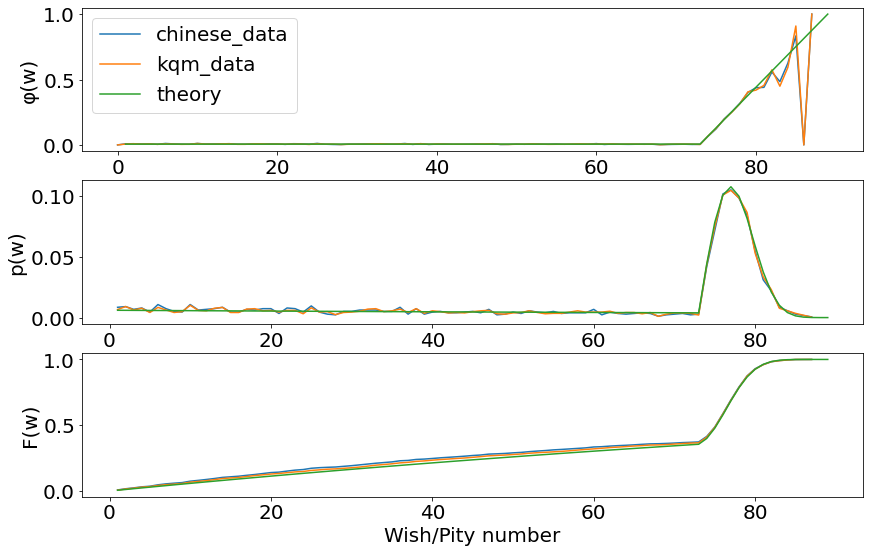

In [46]:
### Event 5-star
pitys = np.array(edf1['Pity'])
locs = edf1['Rarity'] == 5
u, c = np.unique(pitys[locs], return_counts=True)

pitys2 = np.array(edf2['Pity'])
locs2 = edf2['Rarity'] == 5
u2, c2 = np.unique(pitys2[locs2], return_counts=True)

xx = np.arange(1, 90)
plet(xx,e5s_mult, u,c, u2,c2)
# plt.savefig('2_e5s_data.png')

KS 1: 0.44560342203980186
KS 2: 0.46531056891427464


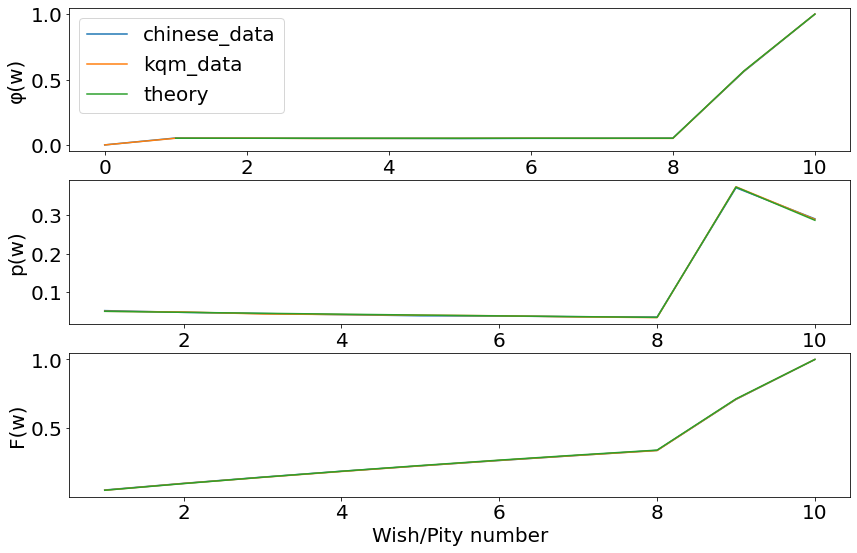

In [49]:
### Event 4-star
h1 = hits_4s(edf1[['Whale_id', 'Rarity']])
h2 = hits_4s(edf2[['Whale_id', 'Rarity']])

u1, c1 = np.unique(h1, return_counts=True)
u2, c2 = np.unique(h2, return_counts=True)

xx = np.arange(1, 11)
plet(xx,e4s_mult, u1,c1, u2,c2)
# plt.savefig('2_e4s_data.png')

KS 1: 1.0246832964686627
KS 2: 0.7110043551495367


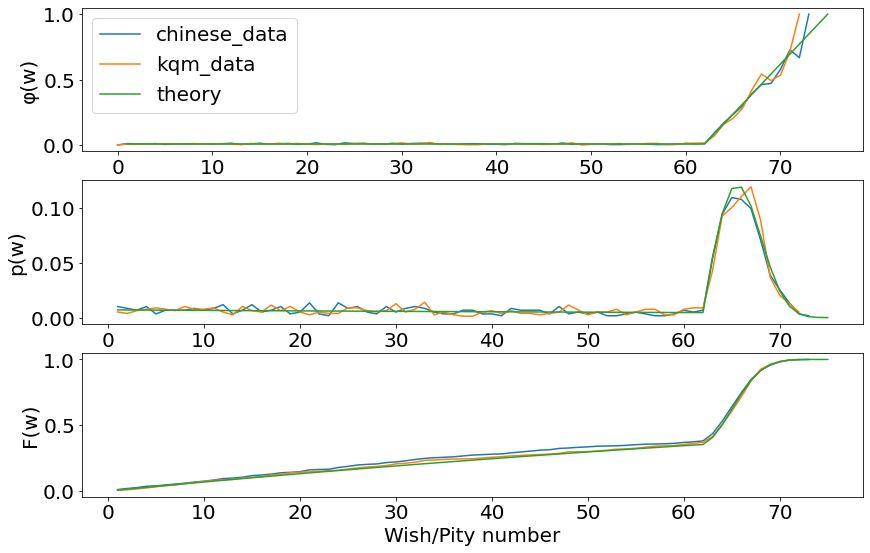

In [61]:
### Weapon 5-star
pitys = np.array(wdf1['Whale_id'])
locs = wdf1['Rarity'] == 5
u1, c1 = np.unique(pitys[locs], return_counts=True)

pitys2 = np.array(wdf2['Pity Count'])
locs2 = wdf2['Rarity (Star)'] == 5
u2, c2 = np.unique(pitys2[locs2], return_counts=True)

xx = np.arange(1, 76)
plet(xx,w5s_mult, u1,c1, u2,c2)
# plt.savefig('2_w5s_data.png')

KS 1: 0.5811160552887005
KS 2: 0.6431290477584347


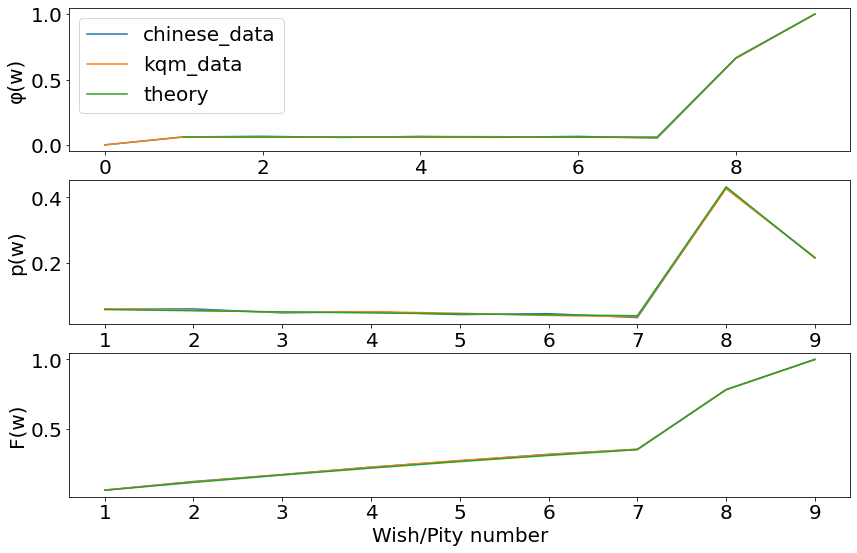

In [65]:
### Weapon 4-star
h1 = hits_4s(wdf1[['Wish', 'Rarity']], hard=9)  # fucked up col names
h2 = hits_4s(wdf2[['Whale_id', 'Rarity (Star)']], hard=9)

u1, c1 = np.unique(h1, return_counts=True)
u2, c2 = np.unique(h2, return_counts=True)

xx = np.arange(1, 10)
plet(xx,w4s_mult, u1,c1, u2,c2)
# plt.savefig('2_w4s_data.png')

KS 1: 0.5811160552887005
KS 2: 0.6431290477584347


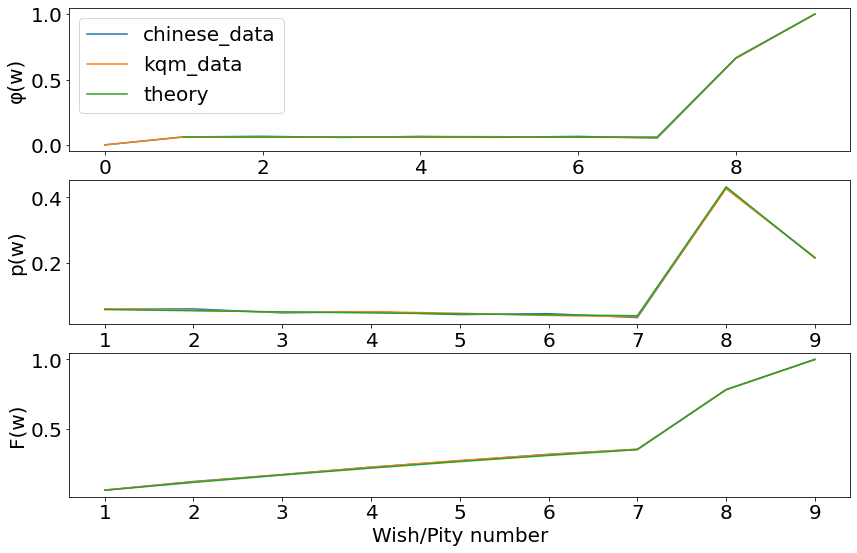

In [66]:
plet(xx,w4s_mult, u1,c1, u2,c2)
plt.savefig('2_w4s_data.png')

In [66]:
whale_pity = {}
hits = []
merc = False
for i, r in df1.iterrows():
    wid = r['Whale_id']
#     wid = r['Wish']  # fucked up cols
    rr = r['Rarity']
    if wid not in whale_pity:
        whale_pity[wid] = 0
    
#     if rr == 5:
#         merc = True
#         continue

    whale_pity[wid] += 1
    if rr == 4:
#         if merc:
#             merc = False
#             whale_pity[wid] = 0
#             continue
        if p['Rarity'] == 5 and whale_pity[wid] > 10:
            hits.append( whale_pity[wid]-1 )
        else:
            hits.append( whale_pity[wid] )
        whale_pity[wid] = 0

    p = r
u4s1, c4s1 = np.unique(hits, return_counts=True)

In [67]:
whale_pity = {}
hits = []
merc = False
for i, r in df2.iterrows():
    wid = r['Whale_id']
    rr = r['Rarity']
    if wid not in whale_pity:
        whale_pity[wid] = 0
        
#     if rr == 5:
#         merc = True
    
    whale_pity[wid] += 1
    if rr == 4:
#         if merc:
#             merc = False
#             whale_pity[wid] = 0
#             continue
        if p['Rarity'] == 5 and whale_pity[wid] > 10:
            hits.append( whale_pity[wid]-1 )
        else:
            hits.append( whale_pity[wid] )
        whale_pity[wid] = 0
    p = r
u4s2, c4s2 = np.unique(hits, return_counts=True)

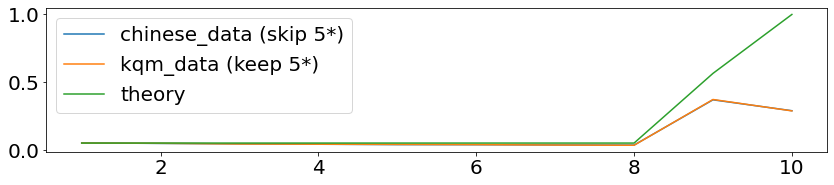

In [72]:
x = np.arange(1, 11)
plt.subplot(311)
plt.plot(x, e4_phw(x))

plt.plot(u4s1, c4s1 / sum(c4s1))
plt.plot(u4s2, c4s2 / sum(c4s2))
# plt.plot(x, y+ss, color='orange')

plt.legend(['chinese_data (skip 5*)', 'kqm_data (keep 5*)', 'theory'])
# plt.title('Char banner 4* data comparison')
# plt.xlabel('Wish/Pity number')
# plt.savefig('w4s_cmp.png')

In [39]:
uc2phw(u4s1, c4s1)

array([0.        , 0.05380011, 0.05215153, 0.05083036, 0.05044559,
       0.0489926 , 0.05070167, 0.05398188, 0.11845952, 1.        ])

In [42]:
u4s1

array([1, 2, 3, 4, 5, 6, 7, 8, 9])

In [71]:
uc2phw(u4s1, c4s1)

array([0.        , 0.05980066, 0.05687363, 0.05548617, 0.05421232,
       0.0524266 , 0.05374644, 0.05457178, 0.05359877, 0.57069953,
       1.        ])

In [72]:
uc2phw(u4s2, c4s2)

array([0.        , 0.0511349 , 0.05194981, 0.04917877, 0.04981975,
       0.05042947, 0.05116537, 0.04988888, 0.05004617, 0.56363401,
       1.        ])

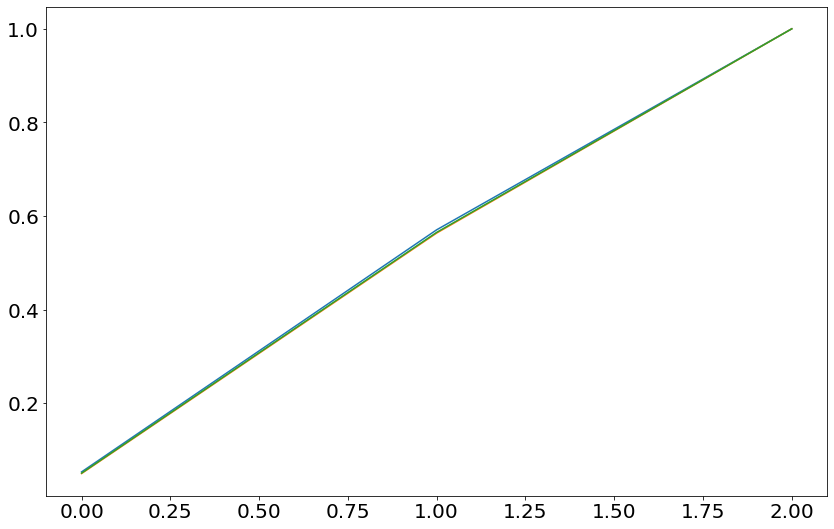

In [74]:

    
plt.plot(uc2phw(u4s1, c4s1)[8:])
plt.plot(uc2phw(u4s2, c4s2)[8:])
plt.plot(e4_phw(np.arange(11))[8:])
# plt.xlim(8, 10)
# plt.plot(uc2phw(u4s1, c4s1) - uc2phw(u4s2, c4s2))

In [13]:
pitys = np.array(df1['Pity'])
# pitys = np.array(df1['Whale_id'])  # Mis-label on weapon data
locs = df1['Rarity'] == 5
u, c = np.unique(pitys[locs], return_counts=True)

In [9]:
pitys2 = np.array(df2['Pity'])
# pitys2 = np.array(df2['Pity Count'])
locs2 = df2['Rarity'] == 5
# locs2 = df2['Rarity (Star)'] == 5
u2, c2 = np.unique(pitys2[locs2], return_counts=True)

In [10]:
e5s_mult = multi_distr.MultiDistr(e5s_pdf, n_max=90)
w5s_mult = multi_distr.MultiDistr(w5s_pdf, n_max=90)

In [26]:
uc2phw(u, c)

array([0.        , 0.00845547, 0.00909608, 0.00688468, 0.00808781,
       0.00465929, 0.01111761, 0.00769231, 0.00536673, 0.00479616,
       0.01144578, 0.00670323, 0.00736196, 0.00803461, 0.00934579,
       0.00503145, 0.00505689, 0.00762389, 0.00704225, 0.00838169,
       0.00845254, 0.00393443, 0.00921659, 0.00863787, 0.00536193,
       0.01145553, 0.00545331, 0.003427  , 0.00275103, 0.0062069 ,
       0.00624566, 0.00768156, 0.00774103, 0.00780142, 0.00643317,
       0.00647482, 0.01086169, 0.00366032, 0.0095518 , 0.0037092 ,
       0.00595681, 0.00674157, 0.00527903, 0.00530705, 0.00609756,
       0.00690184, 0.00540541, 0.00931677, 0.0031348 , 0.00393082,
       0.00631413, 0.00476569, 0.00798085, 0.00643604, 0.00566802,
       0.00732899, 0.00492207, 0.00577082, 0.00580431, 0.0058382 ,
       0.01006711, 0.00338983, 0.00680272, 0.00513699, 0.00430293,
       0.00518583, 0.00608167, 0.00524476, 0.00175747, 0.00352113,
       0.00441696, 0.00532387, 0.00356824, 0.00447628, 0.06654

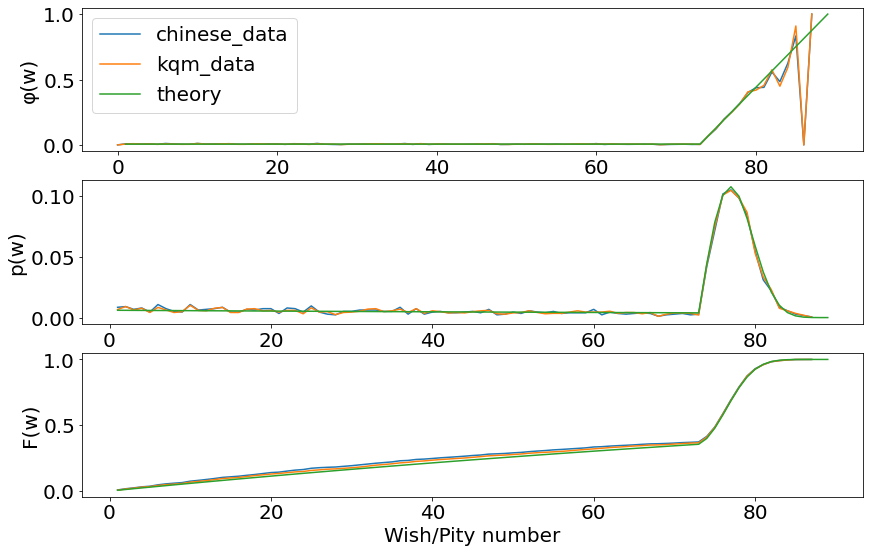

In [45]:
xx = np.arange(1, 90)

plt.subplot(311)
plt.plot(uc2phw(u, c))
plt.plot(uc2phw(u2, c2))
plt.plot(xx, e5_phw(xx))
plt.legend(['chinese_data', 'kqm_data', 'theory'])
plt.ylabel('φ(w)')


plt.subplot(312)
plt.plot(u, c / np.sum(c))
plt.plot(u2, c2 / np.sum(c2))
plt.plot(xx, e5s_mult(xx))
plt.ylabel('p(w)')

# plt.title('Weapon banner 5* data comparison')

plt.subplot(313)
plt.plot(u, np.cumsum(c / np.sum(c)))
plt.plot(u2, np.cumsum(c2 / np.sum(c2)))
plt.plot(xx, np.cumsum(e5s_mult(xx)))
plt.xlabel('Wish/Pity number')
plt.ylabel('F(w)')

# plt.savefig('2_e5s_data.png')

In [49]:
sum(c), sum(c2)

(1774, 2873)

In [53]:
.0357 * np.sqrt(1774)

1.503643993769802

In [55]:
.0217 * np.sqrt(2873)

1.1631280969867421

In [59]:
np.argmax(scipy.special.kolmogorov(np.linspace(0, 2.5, 500)) < .05)
np.linspace(0, 2.5, 500)[272]

1.3627254509018036

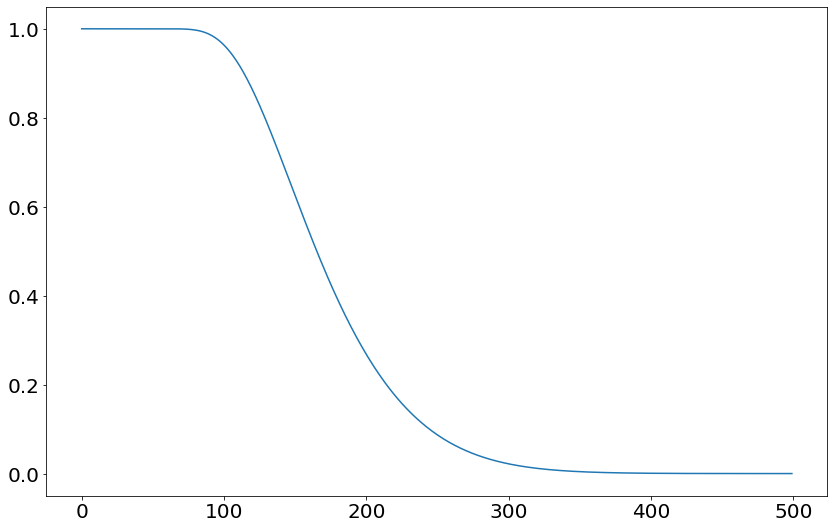

In [54]:
plt.plot(scipy.special.kolmogorov(np.linspace(0, 2.5, 500)))

In [65]:
scipy.special.kolmogi(.05)

1.3580986393225507

In [60]:
np.amax(np.abs(np.cumsum(c / np.sum(c)) - np.cumsum(e5s_mult(u)))) * np.sqrt(sum(c))

1.5041914539071344

In [61]:
np.amax(np.abs(np.cumsum(c2 / np.sum(c2)) - np.cumsum(e5s_mult(u2)))) * np.sqrt(sum(c2))

1.1415667704909827

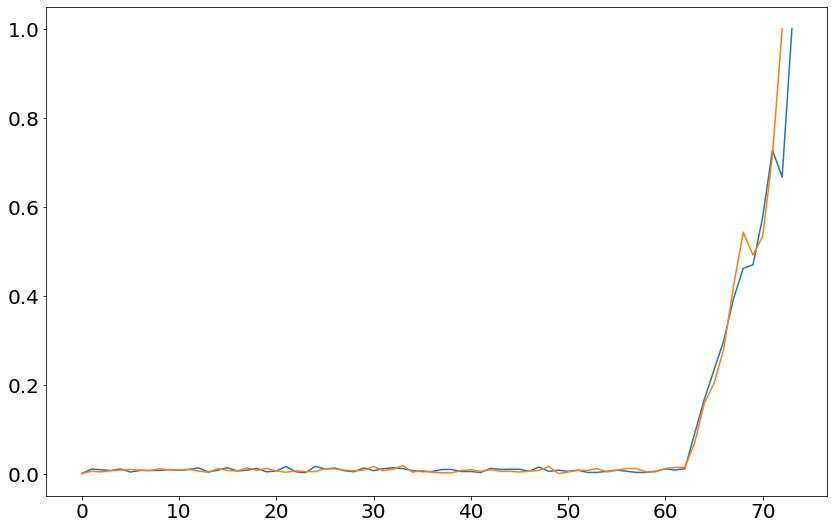

In [518]:
plt.plot(uc2phw(u, c))
plt.plot(uc2phw(u2, c2))